В данном ноутбуке реализован подбор оптимального кол-ва PCA для каждого инструмента с помощью библиотеки optuna

Также по каждому инструменту обучается своя модель линейной регрессии для переода приращений риск-факторов в приращения инструмента

In [1]:
import os

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm

In [2]:
# Обучение проводим включительно по эту дату
split_date = "2020-12-30"

In [3]:
interest_rates = ["cbr_g_curve"]
currencies = ["USD", "CHF"]
indexes = ["BRENT", "GOLD", "IMOEX", "RTSI"]
instruments = [
    "APTK",
    "BELU",
    "FESH",
    "MVID",
    "NKNCP",
    "PHOR",
    "PIKK",
    "RASP",
    "SELG",
    "SNGSP",
    # "YNDX",
    "OFZ_26207",
    "OFZ_26209",
    "OFZ_26211",
    "OFZ_26212",
    "OFZ_26218",
]

In [4]:
def concat_data(files):
    df = []
    for file in files:
        df.append(pd.read_csv(file))
    dfs = df[0]
    for x in df[1:]:
        dfs = pd.merge(dfs, x, on=["Date"], how="outer")

    dfs = dfs[(dfs["Date"] >= "2016-01-01") & (dfs["Date"] < "2022-01-01")].copy()
    dfs.set_index("Date", inplace=True)
    dfs.sort_index(inplace=True)
    dfs.index = pd.to_datetime(dfs.index)
    # dfs.dropna(inplace=True)
    return dfs.copy()

In [5]:
path = "./data/{}.csv"
df_risk = [path.format(x) for x in interest_rates + currencies + indexes]
df_risk = concat_data(df_risk)

df_tools = [path.format(x) for x in instruments]
df_tools = concat_data(df_tools)

common_index = pd.merge(df_risk, df_tools, on=["Date"], how="outer").dropna().index
df_risk = df_risk.loc[common_index].copy()
df_tools = df_tools.loc[common_index].copy()

df = pd.merge(df_risk, df_tools, on=["Date"], how="outer")
features_risk = list(df_risk.columns)
features_tools = list(df_tools.columns) + currencies
print(len(df), len(df_risk), len(df_tools))

1109 1109 1109


In [6]:
train_df = df[df.index <= split_date].pct_change().dropna(axis=0)
test_df = df[df.index > split_date].pct_change().dropna(axis=0)
all_df = df.pct_change().dropna(axis=0)

In [7]:
import optuna
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import TimeSeriesSplit

optuna.logging.set_verbosity(optuna.logging.ERROR)


def get_values(x):
    if isinstance(x, (pd.DataFrame, pd.Series)):
        return x.values
    return x


class Model:
    def __init__(self, n_components=None, pca_args=None, lr_args=None):
        self.pca_args = pca_args or {"random_state": 42}
        self.lr_args = lr_args or {}
        self.pca = PCA(n_components, **self.pca_args)
        self.lr = LinearRegression(**self.lr_args)

    def fit(self, data, target):
        data = get_values(data)
        target = get_values(target)
        data_pca = self.pca.fit_transform(data)
        self.lr.fit(data_pca, target)
        return self

    def predict(self, data):
        data = get_values(data)
        return self.lr.predict(self.pca.transform(data))

    def __repr__(self):
        return "{}({}, {})".format(self.__class__.__name__, self.pca, self.lr)


class AutoModel:
    def __init__(self, cv_splits=5, n_trials=10, max_components=10, metric=None):
        self.splitter = TimeSeriesSplit(cv_splits)
        self.study = optuna.study.create_study(sampler=optuna.samplers.TPESampler(seed=42), direction="maximize")
        self.metric = metric or r2_score
        self.n_trials = n_trials
        self.max_components = max_components

    def fit(self, data, target):
        data = get_values(data)
        target = get_values(target)

        def objective(trial):
            components = trial.suggest_int("n_components", 1, min([self.max_components, *data.shape]))
            for t in trial.study.trials:
                if t.state != optuna.trial.TrialState.COMPLETE:
                    continue
                if t.params == trial.params:
                    raise optuna.exceptions.TrialPruned("Duplicate parameter set")

            scores = []
            for train_idx, test_idx in self.splitter.split(data):
                model = Model(components)
                model.fit(data[train_idx], target[train_idx])
                proba = model.predict(data[test_idx])
                score = self.metric(target[test_idx], proba)
                scores.append(score)
            return np.mean(scores)

        self.study.optimize(objective, self.n_trials)
        return Model(**self.study.best_params).fit(data, target)

In [8]:
m = Model(3)
m.fit(train_df[features_risk], train_df[features_tools])
r2_score(test_df[features_tools], m.predict(test_df[features_risk]))

-0.0221256561456525

In [9]:
results = []

for f in features_tools:
    m = AutoModel().fit(train_df[features_risk], train_df[f])
    score = m.predict(train_df[features_risk])
    score_test = m.predict(test_df[features_risk])
    results.append({
        'tool': f,
        'n_components': m.pca.n_components,
        'r2_train': r2_score(train_df[f], score), 
        'r2_test': r2_score(test_df[f], score_test),
    })
results = pd.DataFrame(results)
results

,tool,n_components,r2_train,r2_test
0,APTK,1,0.024229,-0.026043
1,BELU,1,0.010716,-0.006807
2,FESH,1,0.078049,-0.024617
3,MVID,1,0.009878,-0.019814
4,NKNCP,4,0.041822,-0.008094
5,PHOR,9,0.140284,0.006302
6,PIKK,1,0.028556,-0.000141
7,RASP,7,0.167762,0.004794
8,SELG,1,0.030985,0.008605
9,SNGSP,9,0.160947,-0.091917


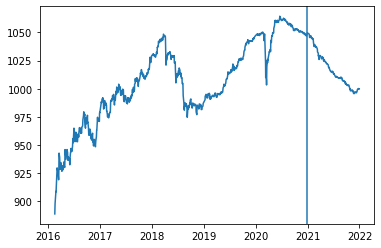

In [10]:
plt.plot(df["OFZ_26209"])
plt.axvline(pd.Timestamp(split_date))